# Catalog matching
Here we match objects from the RBC to objects in the PAndAS catalogues. We iterate over the entire field.


## Initial startup requirements

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii

In [2]:
bounds = pickle.load(open('./pickle/bounds.pk','rb'))

In [3]:
master_cat = pd.read_csv('./catdata/master_catalog_jan_2023.csv') #2184 objects long

In [4]:
cat_files = ['cat1_50.pk','cat51_100.pk','cat101_150.pk','cat151_200.pk','cat201_235.pk',
             'cat236_257.pk','cat258_279.pk','cat280_320.pk','cat321_360.pk','cat361_406.pk']

In [5]:
def load_cat(field): # change to match-case
    bounds = [50,100,150,200,235,257,279,320,360,406]
    for b in range(len(bounds)):
        if field <= bounds[b]:
            to_load = cat_files[b]
            break
    with open(f'./pickle/{to_load}','rb') as f:
        catalogue = pickle.load(f)
    return catalogue

# Define Functions

In [6]:
# match objects in CAT[n] to the ones in master_cat
# matches every object from CAT[n] so the resulting arrays are len(CAT[n]) long
def match_objs(cat_no: int) -> (np.ndarray, np.ndarray):
    d1 = CAT[cat_no]
    ra_obs, dec_obs = d1['RA'], d1['Dec']
    d2 = master_cat
    ra_qry, dec_qry = d2['RADEG'], d2['DECDEG']

    c1 = coord.SkyCoord(ra_obs, dec_obs, unit=(u.degree, u.degree))
    c2 = coord.SkyCoord(ra_qry, dec_qry, unit=(u.degree, u.degree))
    idx, d2d, _ = c1.match_to_catalog_sky(c2)
    return idx,d2d #idx: the index of the object in RBC, d2d: distance to that object from CAT

In [7]:
# find a list of all objects from match_objs that are actually contained within a given field
# as the returned objects of match_objs contains ones from master_cat which are outside of the given field
#   __________
#  |   *     |   *  <-- remove points like this
#  |      *  |
#  |  *    * |
#  |_____*___|
#
def find_objs_in_field(cat_no: int, objs: list) -> list:
    in_field = []
    for o in objs:
        ra = master_cat.loc[o]['RADEG']
        dec = master_cat.loc[o]['DECDEG']
        x0,x1,y0,y1 = bounds[cat_no]
        if ( ra<x0 and ra>x1 and dec>y0 and dec<y1 ):
            in_field.append(master_cat.loc[o])
    return in_field

In [8]:
#### *old function*
##### find the closest match(es) for each object in the master_list, that is in a given field
def find_closest_match_OLD(cat_no: int, in_field: list, crowding_limit: int, delta: float) -> list:  
    ret = []
    
    #TEMP
    crowded_objects = []
    
    for obj in in_field:
        idx = obj.name #obj.name is the position/index of the object in master_cat
        delta_filter = d2d_idx_df[d2d_idx_df['idx']==idx]['d2d'] < delta
        obj_delta = d2d_idx_df[d2d_idx_df['idx']==idx][delta_filter] # returns list of objects within delta of the position from master_cat
        
        if len(obj_delta) > crowding_limit:
            crowded_objects.append((idx,len(obj_delta)))
            continue
        else:
            closest_obj_idx = d2d_idx_df[d2d_idx_df['idx']==idx]['d2d'].idxmin() #find only the closest object
            out = (closest_obj_idx,idx) # return index of object in CAT[n] and index in master_cat 
        ret.append(out)
    return ret, crowded_objects

In [9]:
# find the closest match(es) for each object in the master_list, that is in a given field
# returns a list of 3-tuples of the format (CAT index, master_cat index, nearby obj count)
def find_closest_match(in_field: list, delta: float) -> list:
    ret = []
    
    for obj in in_field:
        idx = obj.name #obj.name is the position/index of the object in master_cat
        delta_filter = d2d_idx_df[d2d_idx_df['idx']==idx]['d2d'] < delta
        obj_delta = d2d_idx_df[d2d_idx_df['idx']==idx][delta_filter] # returns list of objects within delta of the position from master_cat
        
        # 08/02/23 : commented the next three lines
        #closest_obj_idx = d2d_idx_df[d2d_idx_df['idx']==idx]['d2d'].idxmin() #find only the closest object
        #if d2d_idx_df.loc[closest_obj_idx]['d2d'] > 0.001:# REVISE THIS, 0.001 seems good
        #    continue # skip objects which dont have a nearby match
            
        # filter matches by dg/di values
        closest_obj_idx = -1
        for i in obj_delta.sort_values('d2d').index:
            if CAT[c][i]['di'] > 0.05 or CAT[c][i]['dg'] > 0.05:
                continue
            elif (obj_delta[obj_delta.index==i]['d2d'] < 0.0005).bool(): #ensure the point is nearby (1.8 arcsec)
                closest_obj_idx = i # if the dg/di is in the right range (and close enough to true position) then use that index
                break
        if closest_obj_idx == -1: # if no matches were found in the above for loop
            continue # skip this object as there are no reasonable matches
        
        out = (closest_obj_idx, idx, len(obj_delta)) # return index of object in CAT[n], index in master_cat, and number of nearby objects(for crowding analysis)
        ret.append(out)
    return ret

# SKIP


[Skip to the main loop](#1)  
[Skip to the results](#2)

## Set Field Bounds & Save

In [14]:
# define the bounds of each field
# (x0,y0) <-> (x1,y1) is the bounding box of the field
# note that since RA *decreases* in the easterly direction, we take x1 to be the minimum value of RA
bounds = {}

def find_bounds():
    for c in CAT:
        #lower left corner
        x0 = max(CAT[c]['RA'])
        y0 = min(CAT[c]['Dec'])
        #upper right corner
        x1 = min(CAT[c]['RA'])
        y1 = max(CAT[c]['Dec'])
        bounds[c] = (x0,x1,y0,y1)

In [15]:
for f_ in cat_files:
    print(f_)
    CAT = pickle.load(open(f'./pickle/{f_}','rb'))
    find_bounds()
    del CAT

with open('./pickle/bounds.pk','wb') as f:
    pickle.dump(bounds,f)
print('done')

cat1_50.pk


KeyboardInterrupt: 

In [16]:
bounds = pickle.load(open('./pickle/bounds.pk','rb'))

## Test for specific field
[(Skip)](#1)

In [17]:
def load_cat(field):
    bounds = [50,100,150,200,235,257,279,320,360,406]
    for b in range(len(bounds)):
        if field <= bounds[b]:
            to_load = cat_files[b]
            break
    print(f'Loading {to_load} ...')
    catalogue = pickle.load(open(f'./pickle/{to_load}','rb'))
    return catalogue

In [40]:
field = 5
c = field
CAT = load_cat(field)
# get indexes and distances for the field
idx, d2d = match_objs(field)

# convert to degrees
d2d = d2d.degree

# zip both lists into a single list of tuples
d2d_idx_tuples = [(d2d[i],idx[i]) for i in range(len(d2d))]

# arrange into a pd.DF
d2d_idx_df = pd.DataFrame(d2d_idx_tuples, columns=['d2d','idx'])

# create a list of individual objects present in the field
objs=set(idx)

# get all objects which are actually within the field
in_field = find_objs_in_field(field,objs)

# Work out effective values of delta:
# find the shortest distances for each master_cat object
min_distances = []
for obj in in_field:
    min_distances.append(d2d_idx_df[d2d_idx_df['idx']==obj.name].min()['d2d'])

Loading cat1_50.pk ...


In [41]:
d2d_idx_df

,d2d,idx
0,0.241153,2647
1,0.223649,2647
2,0.145579,2647
3,0.328166,2647
4,0.305305,2647
...,...,...
150099,1.104462,2647
150100,1.104934,2647
150101,1.104389,2647
150102,1.105283,2647


In [42]:
min_distances

[0.00037374400971860387]

In [43]:
(obj_del[obj_del.index == 101330]['d2d'] < 0.0005).bool()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [44]:
test_obj_id = in_field[0].name
in_field

[ID                   HM33-A
 RADEG             23.924083
 DECDEG            28.820972
 CLASS                   1.0
 DATATABLE    huxor09_table1
 Name: 2647, dtype: object]

In [ ]:
# create a filter for objects in CAT which are closer than delta to their corresponding master_cat object
filter1 = d2d_idx_df[d2d_idx_df['idx']==test_obj_id]['d2d'] < 0.006 # what value of delta???????? how much RA/Dec dist is allowed

# apply the filter
obj_del = d2d_idx_df[d2d_idx_df['idx']==test_obj_id][filter1]

In [22]:
obj_del

,d2d,idx
39641,0.003931,2647
39696,0.000391,2647
39710,0.000432,2647
39739,0.000826,2647
39770,0.000417,2647
39775,0.000753,2647
39800,0.000374,2647
39849,0.001260,2647
39854,0.004029,2647
39866,0.001319,2647


## Plot objects around master_cat[test_obj_id]

In [23]:
CAT[402][101330]

KeyError: 402

In [24]:
test_object = master_cat.loc[test_obj_id]
test_object

ID                   HM33-A
RADEG             23.924083
DECDEG            28.820972
CLASS                   1.0
DATATABLE    huxor09_table1
Name: 2647, dtype: object

In [25]:
points_ra = [CAT[field][n]['RA'] for n in obj_del.index]

In [26]:
points_dec = [CAT[field][n]['Dec'] for n in obj_del.index]

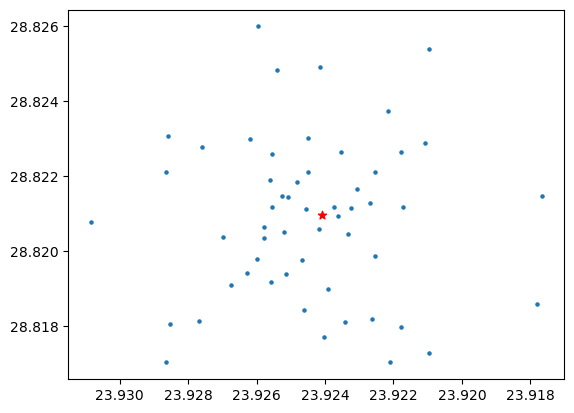

In [27]:
plt.figure(dpi=100)
plt.scatter(test_object.RADEG, test_object.DECDEG, marker="*", c='red')
plt.scatter(points_ra,points_dec, s=5)

plt.gca().invert_xaxis()
#plt.savefig('hm33-d.png', transparent=True)

## Gather values to create DS9 Regions

In [ ]:
regions = {}

In [ ]:
for cat_f in cat_files:
    print(f'\n{cat_f}')
    CAT = pickle.load(open(f'./pickle/{cat_f}','rb'))
    regions = {} # start with a fresh dictionary
    
    for c in CAT:
        regions[c] = []
        
        idx,d2d = match_objs(c)
        objs = set(idx)
        d2d = d2d.degree
        
        d2d_idx_tuples = [(d2d[i],idx[i]) for i in range(len(d2d))]
        d2d_idx_df = pd.DataFrame(d2d_idx_tuples, columns=['d2d','idx'])
        
        # get the list of all obj from master_cat which are in the field CAT[c]
        in_field = find_objs_in_field(c,objs)
        #print(in_field)
        #input()
        for obj in in_field:
            obj_ID = obj.ID # extract known object values
            print(f'{obj_ID}...')
            obj_RA = obj.RADEG
            obj_DEC = obj.DECDEG
            
            pts_list = []
            # create a filter for objects in CAT which are closer than delta to their corresponding master_cat object
            filter1 = d2d_idx_df[d2d_idx_df['idx']==obj.name]['d2d'] < 0.006
            # apply the filter
            obj_del = d2d_idx_df[d2d_idx_df['idx']==obj.name][filter1]

            for i in obj_del.index: # iterate through indexes of each nearby point, add to list
                cat_RA = CAT[c][i]['RA']
                cat_DEC = CAT[c][i]['Dec']
                pts_list.append( (cat_RA,cat_DEC) )
            
            # add the data for the object from master_cat
            regions[c].append( (obj_ID,obj_RA,obj_DEC,pts_list) )
    print('Writing...\n')
    # dump data for the current CAT range
    with open(f'./pickle/region_data/{cat_f[:-3]}_region_data.pk','wb') as f_:
        pickle.dump(regions,f_)
        
print('Done!')

<a id="1"></a>
# Main Loop


In [28]:
cat_files = ['cat1_50.pk','cat51_100.pk','cat101_150.pk','cat151_200.pk','cat201_235.pk',
             'cat236_257.pk','cat258_279.pk','cat280_320.pk','cat321_360.pk','cat361_406.pk']

In [10]:
matches = {}

#TEMP
#crowded_objects_masterlist = []

for f in cat_files:
    print(f'\n{f}')
    CAT = pickle.load(open(f'./pickle/{f}','rb'))
    print('Loaded...')
    for c in CAT:
        idx,d2d = match_objs(c)
        objs = set(idx)
        d2d = d2d.degree
        
        d2d_idx_tuples = [(d2d[i],idx[i]) for i in range(len(d2d))]
        
        d2d_idx_df = pd.DataFrame(d2d_idx_tuples, columns=['d2d','idx'])
        
        # get the list of all obj from master_cat which are in the field CAT[c]
        in_field = find_objs_in_field(c,objs)
        delta = 0.005 # the size of the region in which to determine crowding (0.006 deg = 21.6 arcsec)
        matches[c] = find_closest_match(in_field, delta=delta)
        
        #TEMP
        #matches[c], crowded_objects = find_closest_match_OLD(c, in_field, crowding_limit=100, delta=delta)
        #crowded_objects_masterlist += crowded_objects
        
print('Done!')


cat1_50.pk
Loaded...

cat51_100.pk
Loaded...

cat101_150.pk
Loaded...

cat151_200.pk
Loaded...

cat201_235.pk
Loaded...

cat236_257.pk
Loaded...

cat258_279.pk
Loaded...

cat280_320.pk
Loaded...

cat321_360.pk
Loaded...

cat361_406.pk
Loaded...
Done!


In [11]:
# remove crowded objects and empty fields
empty_fields = []
for c in range(1,407):
    if matches[c] == []:
        empty_fields.append(c)
        matches.pop(c,None)

In [12]:
with open('./pickle/matches/matches_delta005_1702.pk','wb') as f:
    pickle.dump(matches,f)

In [13]:
with open('./pickle/matches/emptyfields_delta005_1702.pk','wb') as f:
    pickle.dump(empty_fields,f)

<a id="2"></a>
# Test

In [ ]:
# find the closest match(es) for each object in the master_list, that is in a given field
# returns a list of 3-tuples of the format (CAT index, master_cat index, nearby obj count)
def find_closest_match(in_field: list, delta: float) -> list:
    ret = []
    
    for obj in in_field:
        idx = obj.name #obj.name is the position/index of the object in master_cat
        delta_filter = d2d_idx_df[d2d_idx_df['idx']==idx]['d2d'] < delta
        obj_delta = d2d_idx_df[d2d_idx_df['idx']==idx][delta_filter] # returns list of objects within delta of the position from master_cat
        
        # 08/02/23 : commented the next three lines
        #closest_obj_idx = d2d_idx_df[d2d_idx_df['idx']==idx]['d2d'].idxmin() #find only the closest object
        #if d2d_idx_df.loc[closest_obj_idx]['d2d'] > 0.001:# REVISE THIS, 0.001 seems good
        #    continue # skip objects which dont have a nearby match
            
        # filter matches by dg/di values
        closest_obj_idx = -1
        for i in obj_delta.sort_values('d2d').index:
            if CAT[c][i]['di'] > 0.05 or CAT[c][i]['dg'] > 0.05:
                continue
            elif (obj_delta[obj_delta.index==i]['d2d'] < 0.0005).bool(): #ensure the point is nearby (1.8 arcsec)
                closest_obj_idx = i # if the dg/di is in the right range (and close enough to true position) then use that index
                break
        if closest_obj_idx == -1: # if no matches were found in the above for loop
            continue # skip this object as there are no reasonable matches
        
        out = (closest_obj_idx, idx, len(obj_delta)) # return index of object in CAT[n], index in master_cat, and number of nearby objects(for crowding analysis)
        ret.append(out)
    return ret

In [29]:
# find the closest match(es) for each object in the master_list, that is in a given field
# returns a list of 3-tuples of the format (CAT index, master_cat index, nearby obj count)
def find_closest_match_2(in_field: list, delta: float) -> list:
    ret = []
    no_nearby = []
    for obj in in_field:
        idx = obj.name #obj.name is the position/index of the object in master_cat
        delta_filter = d2d_idx_df[d2d_idx_df['idx']==idx]['d2d'] < delta
        obj_delta = d2d_idx_df[d2d_idx_df['idx']==idx][delta_filter] # returns list of objects within delta of the position from master_cat
        
        closest_obj_idx = d2d_idx_df[d2d_idx_df['idx']==idx]['d2d'].idxmin() #find only the closest object
        if d2d_idx_df.loc[closest_obj_idx]['d2d'] > 0.001:# REVISE THIS # if closest object is not actually nearby then remove
            print(d2d_idx_df.loc[closest_obj_idx]['d2d'])
            no_nearby.append((obj_delta, idx))
            continue # skip objects which dont have a nearby match
        out = (closest_obj_idx, idx, len(obj_delta)) # return index of object in CAT[n], index in master_cat, and number of nearby objects(for crowding analysis)
        ret.append(out)
    return ret, no_nearby

In [30]:
cat_files

['cat1_50.pk',
 'cat51_100.pk',
 'cat101_150.pk',
 'cat151_200.pk',
 'cat201_235.pk',
 'cat236_257.pk',
 'cat258_279.pk',
 'cat280_320.pk',
 'cat321_360.pk',
 'cat361_406.pk']

In [31]:
f = cat_files[0]

In [33]:
matches = {}

#TEMP
#crowded_objects_masterlist = []

for f in cat_files:
    print(f'\n{f}')
    CAT = pickle.load(open(f'./pickle/{f}','rb'))
    print('Loaded...')
    for c in CAT:
        idx,d2d = match_objs(c)
        objs = set(idx)
        d2d = d2d.degree
        
        d2d_idx_tuples = [(d2d[i],idx[i]) for i in range(len(d2d))]
        
        d2d_idx_df = pd.DataFrame(d2d_idx_tuples, columns=['d2d','idx'])
        
        # get the list of all obj from master_cat which are in the field CAT[c]
        in_field = find_objs_in_field(c,objs)
        delta = 0.005 # the size of the region in which to determine crowding (~18 arcsec)
        matches[c] = (find_closest_match_2(in_field, delta=delta), in_field)
        
        #TEMP
        #matches[c], crowded_objects = find_closest_match_OLD(c, in_field, crowding_limit=100, delta=delta)
        #crowded_objects_masterlist += crowded_objects
        
print('Done!')


cat1_50.pk
Loaded...

cat51_100.pk
Loaded...

cat101_150.pk
Loaded...
0.008375699079213395

cat151_200.pk
Loaded...
0.00740128685710147
0.00966375998262728

cat201_235.pk
Loaded...
0.001259126854366083
0.0011958029480312142
0.006204880203360924
0.0013689966198197278
0.0011654833714311494
0.001209771775304332
0.03557565843930179
0.01293721309299256
0.022011922375554493
0.004546958993726279
0.005470002857483397
0.017695854355017308
0.03147408996429449
0.04313212968914575
0.038839673499752266
0.044346330101586645
1.2643191885457408
0.00122438083120858
0.00907443025837842
0.0024756843869177788
0.003978741110986454
0.0011639948529627287
0.005550707288669565
0.0011882510094905787
0.005924938864925702
0.0076354144567997205
0.0017453403554744383
0.0033534008080274595
0.005801458948419279
0.004856561509254716
0.007425958506343858
0.008395351243017693
0.0027737389127154215
0.0038419550953812096
0.014949594241246363
0.003974910549171548
0.0032539823491143116
0.0016906519976775053
0.0070989330601

In [66]:
field_count = {}
running_total = 0
for c in matches:
    no_nearby = matches[c][0][1]
    if no_nearby != []:
        field_count[c] = len(no_nearby)
        running_total += len(no_nearby)
        for i in no_nearby:
            print(i[1],c)

2619 128
98 167
1044 169
35 205
57 207
2231 208
313 210
201 210
212 210
139 212
152 212
155 212
1814 214
2330 214
2075 214
1986 214
1990 214
1999 214
2007 214
9 220
570 228
620 228
1774 228
908 228
967 228
119 231
2324 232
2373 232
2374 232
1989 232
1990 232
1999 232
2007 232
146 233
257 233
341 233
346 233
347 233
495 233
2540 234
2222 235
2315 235
2357 235
1908 235
2665 241
2 241
2076 248
2083 248
2165 248
2301 248
745 248
746 248
748 248
749 248
750 248
753 248
756 248
767 248
777 248
799 248
803 248
812 248
890 248
894 248
897 248
901 248
923 248
955 248
962 248
975 248
978 248
1000 248
1002 248
1010 248
1015 248
1024 248
1040 248
1064 248
1066 248
1112 248
1114 248
1116 248
1127 248
1133 248
1149 248
1175 248
1206 248
1209 248
1232 248
1269 248
1374 248
1426 248
1467 248
1579 248
1586 248
1607 248
1664 248
1695 248
1784 248
1795 248
1827 248
291 249
294 249
348 249
477 249
490 249
603 249
646 249
684 249
704 249
720 249
756 249
767 249
777 249
799 249
803 249
812 249
819 249
159 2